In [1213]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1239]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings('ignore')
from category_encoders.cat_boost import CatBoostEncoder
from functools import reduce

from ydata_profiling import ProfileReport
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna

#### Import dataset

In [1215]:
def load_data():
    train_data = pd.read_csv('train.csv',index_col='Id')
    test_data = pd.read_csv('test.csv',index_col='Id')
    all_data = pd.concat([train_data,test_data],sort=True).reset_index(drop=True)

    return train_data,test_data,all_data

train_data,test_data,all_data = load_data()

In [1216]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [1217]:
all_data.items()

<generator object DataFrame.items at 0x15f6c5210>

There are in total 79 initial features. 

Why do we need data_description?

In [1218]:
# Clean typos -- inproper naming
all_data['Exterior2nd'] = all_data['Exterior2nd'].replace({'Brk Cmn': 'BrkComm'})

# Clean typo -- a corrupt year in GarageYBlt, which is not supposed to be '2207'

# deal with the corrupt ones
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].where(all_data['GarageYrBlt'] <= 2010,all_data['YearBuilt'])

# For convenience, rename squarefeet coloumns
rename = {
    '1stFlrSF':'FirstFlrSF',
    '2ndFlrSF':'SecondFlrSF',
    '3SsnPorch':'ThreeSeasonPorch'}

all_data.rename(columns=rename,inplace=True)

How to identify datatype (numeric, continuous, categoricals...)
1. Numerical
    1. Continuous (float) -- Do not encode
    2. Discrete / Count (int) -- Do not encode
2. Categorical
    1. Nominal (low cardinality -- Yes or No) -- One hot encoding
    2. Nominal (high cardinality) -- Target encoding
    3. Ordinal (e.g. sth related to quality) -- Label Mapping
3. Temporal
    1. Cyclical (e.g. monthsold) -- sin/cos encoding
    2. Interval (e.g. yearbuilt,yearsold) -- Engineering, calculate 'Age' instead

In [1219]:
# So for numerical features, we dont need to encode
# Here we try to identify categorical nominal features

cat_nom_features = ['MSSubClass','MSZoning','Street','Alley',
                    'LandContour','Utilities','LotConfig','Neighborhood',
                    'Condition1','Condition2','BldgType','HouseStyle',
                    'RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                    'MasVnrType','Foundation','Heating',
                    'GarageType','CentralAir','MiscFeature','SaleType',
                    'SaleCondition']

# Here we try to encode categorical ordinal feature -- quality related

# first identify the five/ten level that used to measure the quality

five_levels = ['Po','Fa','TA','Gd','Ex']  # from low quality to high
ten_levels = list(range(10))

manual_orders = {
    'OverallQual': ten_levels,
    'OverallCond': ten_levels,
    'ExterQual': five_levels,
    'ExterCond': five_levels,
    'BsmtQual': five_levels,
    'BsmtCond': five_levels,
    'HeatingQC': five_levels,
    'KitchenQual': five_levels,
    'FireplaceQu': five_levels,
    'GarageQual': five_levels,
    'GarageCond': five_levels,
    'PoolQC':['Fa','TA','Gd','Ex'],
    'LotShape': ['IR3','IR2','IR1','Reg'],
    'Utilities': ['ELO','NoSeWa','NoSewr','AllPub'],
    'LandSlope': ['Sev','Mod','Gtl'],
    'BsmtExposure': ['No','Mn','Av','Gd'],
    'BsmtFinType1': ['Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'BsmtFinType2': ['Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'Electrical': ['Mix','FuseP','FuseF','FuseA','SBrkr'],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    'GarageFinish': ['Unf','RFn','Fin'],
    'Fence': ['MnWw','GdWo','MnPrv','GdPrv'],
    'CentralAir': ['N','Y'],
    'PavedDrive': ['N','P','Y'],
}

# create a new dictionary -- add 'None' into every levels
updated_orders = {}
for key,value in manual_orders.items():
        updated_orders[key] = ['None'] + [str(x) for x in value]


def cat_encode(df):
    # Reminder -- dont modify the dataset itself here
    df = df.copy()
    # Encoding ordinal features
    for key,value in updated_orders.items():
        # Fill null before operating
        df[key] = df[key].fillna('None')
        # Make sure they are strings
        df[key] = df[key].astype(str)
        
        # This defines the strict order, 
        # makes ['Po','Fa','TA','Gd','Ex'] equivalent [0,1,2,3,4], while 0<1<2<3<4
        df[key] = df[key].astype(CategoricalDtype(categories=value,ordered=True))

        # This make ['Po','Fa','TA','Gd','Ex'] transformed into [0,1,2,3,4]
        df[key] = df[key].cat.codes

    # Encoding nominal features -- Not using One-hot encoding is for XGBoost/LightGBM
    for name in cat_nom_features: 
        df[name] = df[name].fillna('None')
        df[name] = df[name].astype("category")
        df[name] = df[name].cat.codes # This returns a unique categroy label for the categorical varaivles
        
    return df

all_data = cat_encode(all_data)
print(all_data['Fence'].value_counts())

Fence
0    2348
3     329
4     118
2     112
1      12
Name: count, dtype: int64


After encoding, we are going to take a look at the missing data and impute them. 

In [1220]:
# Check what is missing there
print(all_data.select_dtypes("number").isnull().sum())

all_data['Alley'].value_counts()

FirstFlrSF          0
SecondFlrSF         0
ThreeSeasonPorch    0
Alley               0
BedroomAbvGr        0
                   ..
Utilities           0
WoodDeckSF          0
YearBuilt           0
YearRemodAdd        0
YrSold              0
Length: 80, dtype: int64


Alley
1    2721
0     120
2      78
Name: count, dtype: int64

In [1221]:
# Fill basement / mansonry veneer related features' missing values with 0

zero_fill_features = ['BsmtFinSF1','BsmtFinSF2','BsmtFullBath','BsmtHalfBath',
                      'BsmtUnfSF','GarageArea','GarageCars','TotalBsmtSF','MasVnrArea']

for name in zero_fill_features:
    all_data[name] = all_data[name].fillna(0)

Here we raise one problem: 
Every house has a lot frontage area, we cannot fill them with simply '0'. 

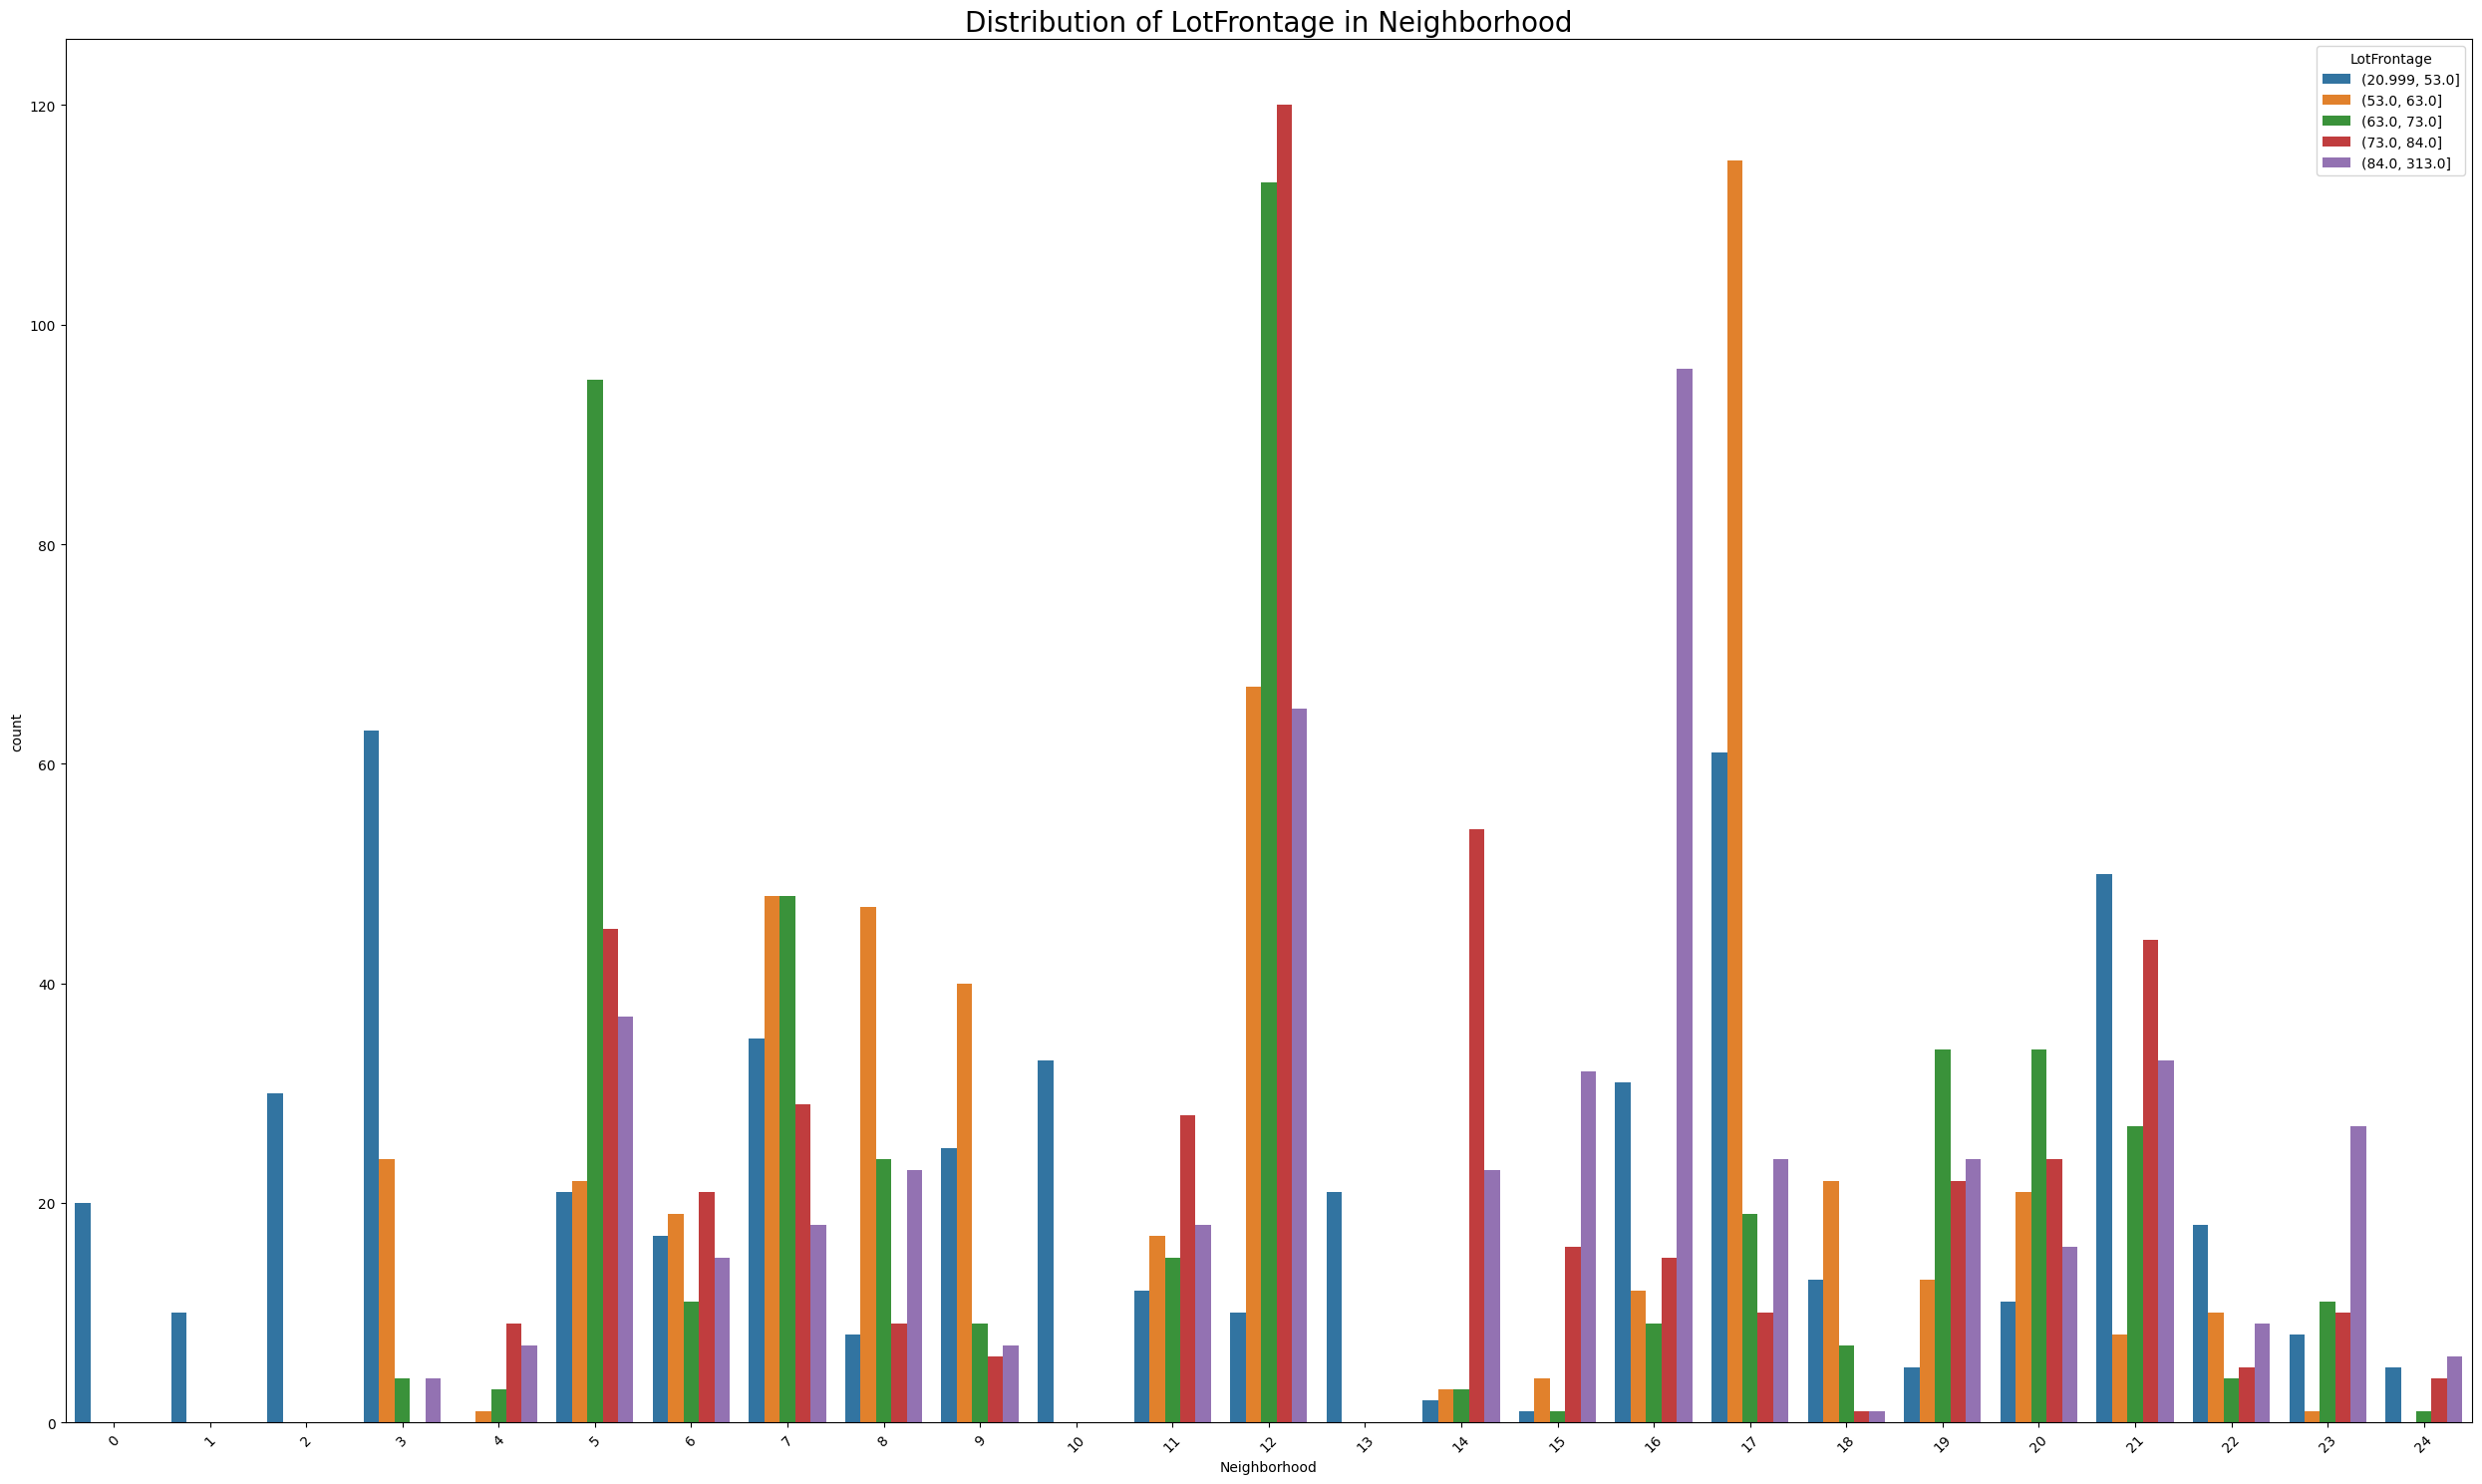

In [1222]:
# LtFrontage is often related to the neighborhood -- which area / what kind of block 
# are you living in

plt.figure(figsize=(25,15))
def neighbor_LotFrontage_corr(df):
    df = df.copy()
    df['LotFrontage'] = pd.qcut(df['LotFrontage'],5)
    ax[1] = sns.countplot(data=df,x='Neighborhood',hue='LotFrontage')
    plt.xticks(rotation=45)
    plt.title('Distribution of LotFrontage in Neighborhood',size=20)
    plt.tight_layout()
    plt.show()

neighbor_LotFrontage_corr(all_data)

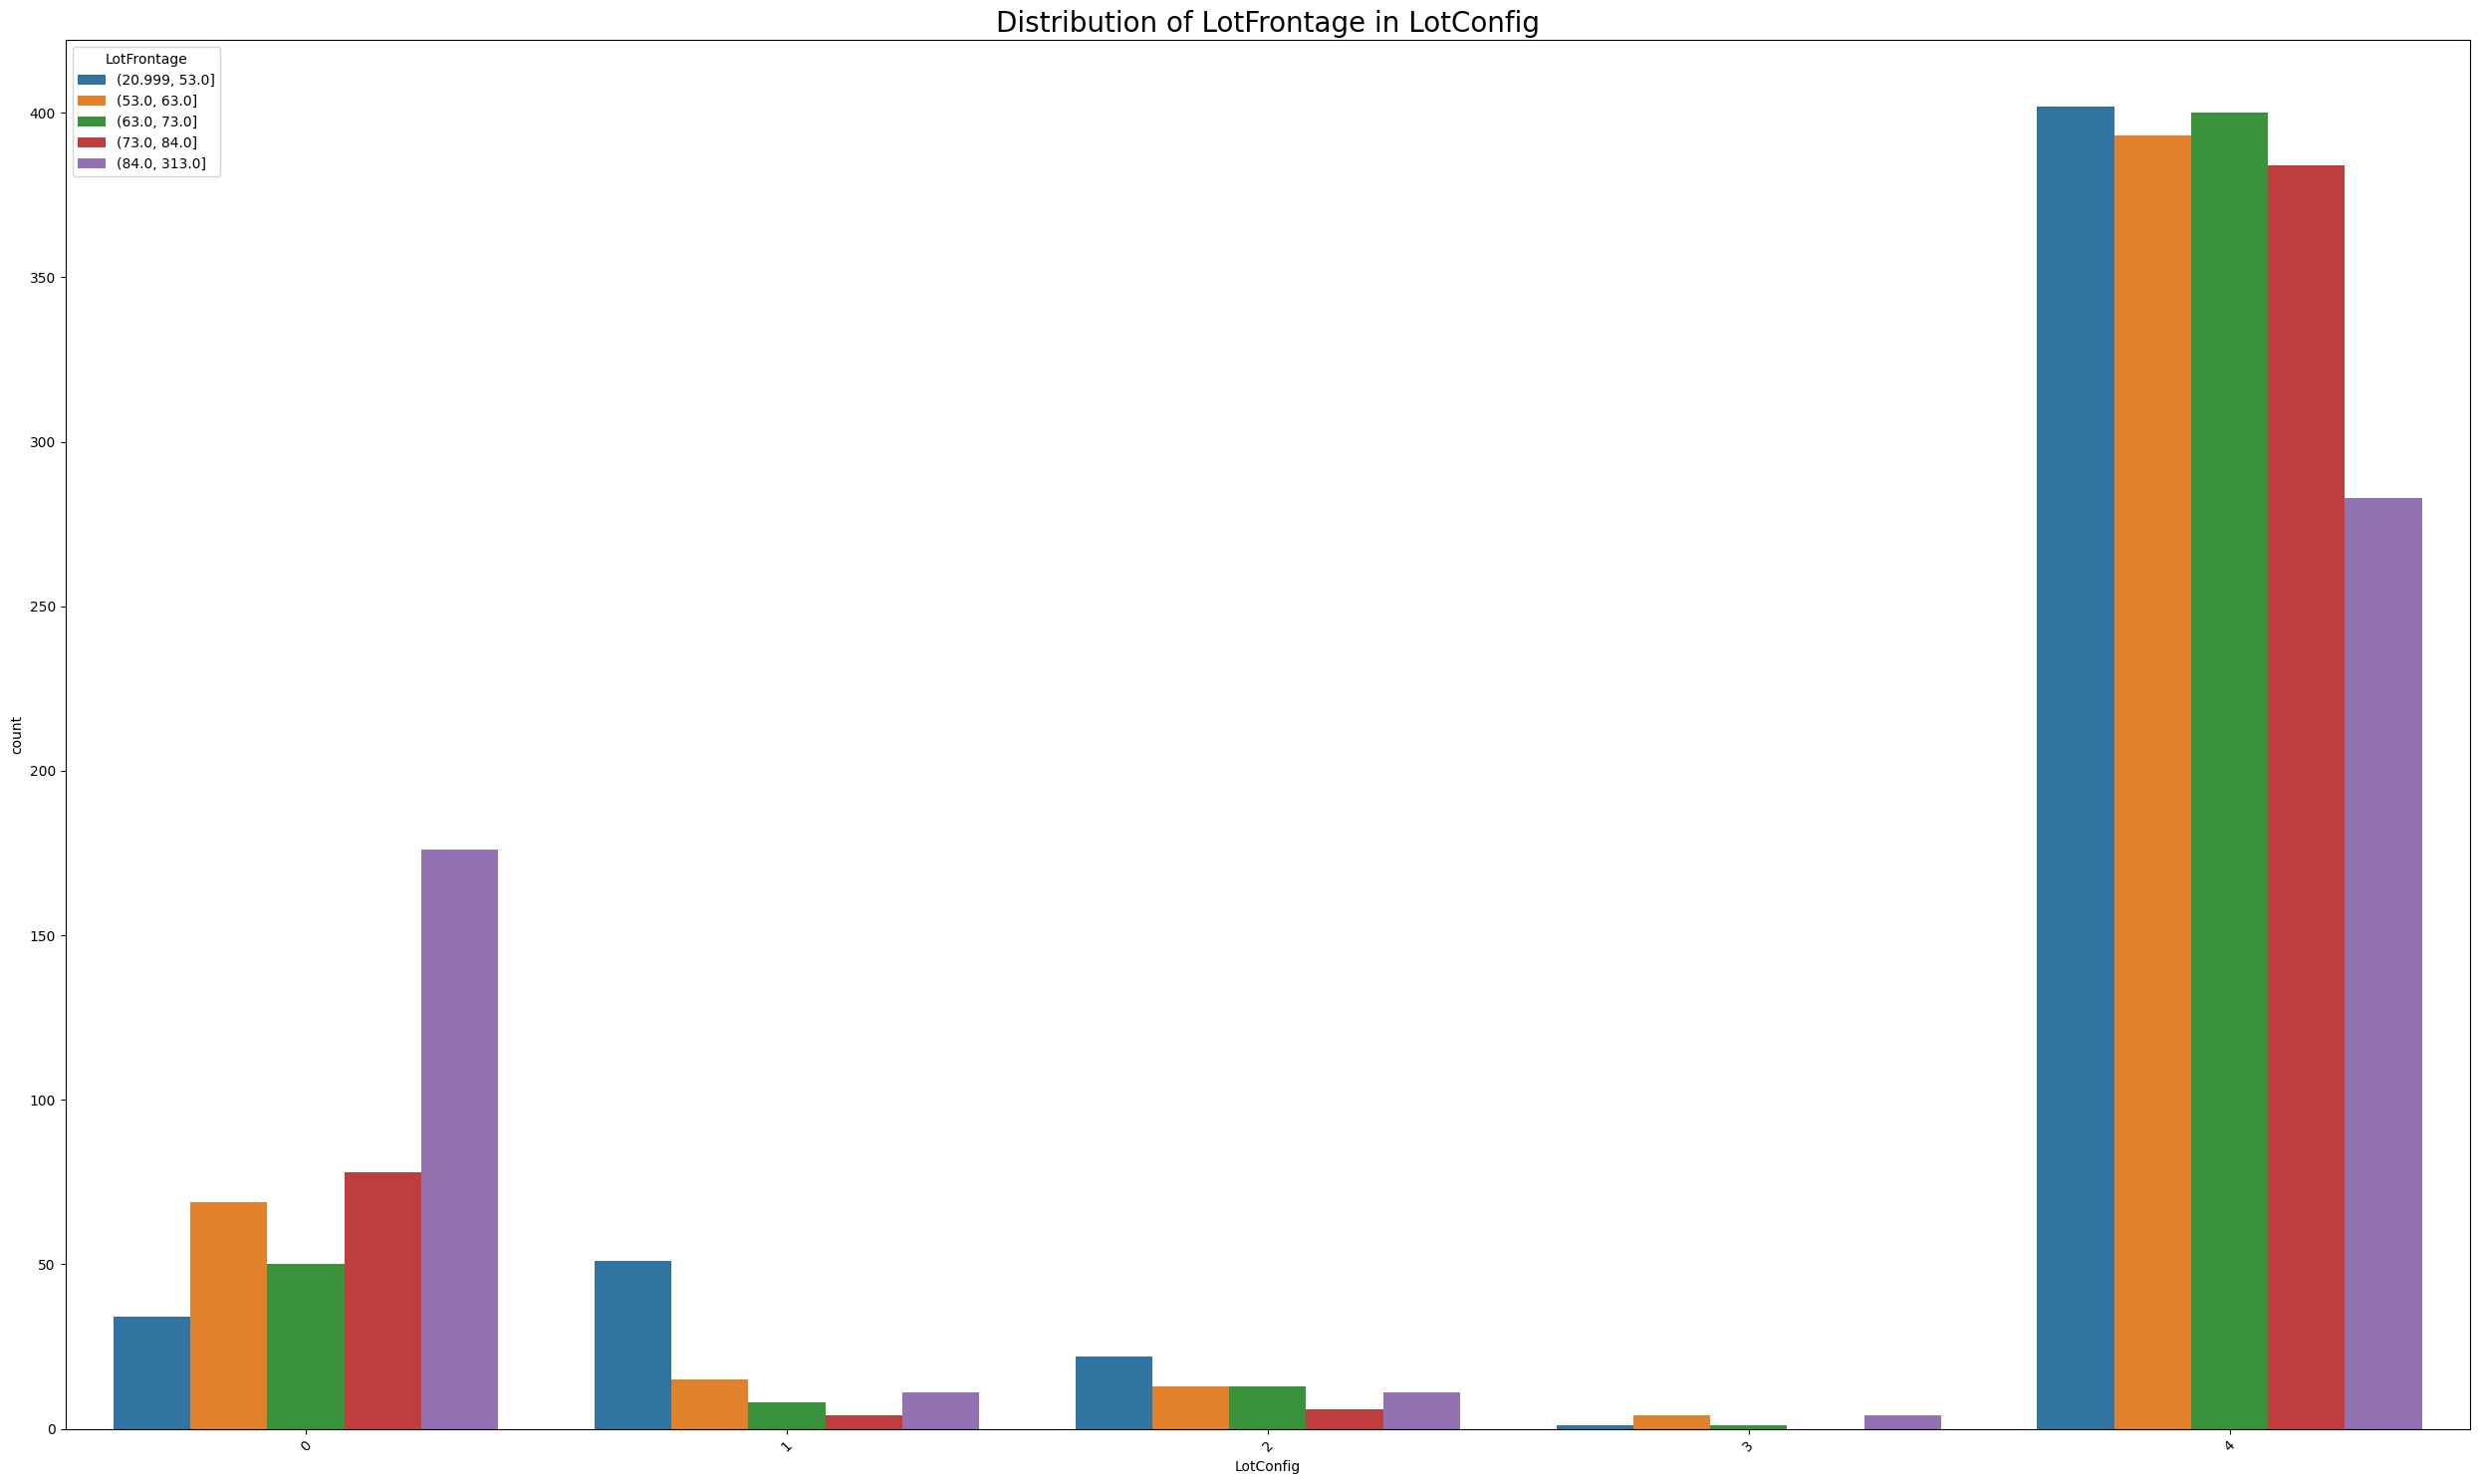

In [1223]:
plt.figure(figsize=(25,15))
def LotConfig_LotFrontage_corr(df):
    df = df.copy()
    df['LotFrontage'] = pd.qcut(df['LotFrontage'],5)
    ax[1] = sns.countplot(data=df,x='LotConfig',hue='LotFrontage')
    plt.xticks(rotation=45)
    plt.title('Distribution of LotFrontage in LotConfig',size=20)
    plt.tight_layout()
    plt.show()

LotConfig_LotFrontage_corr(all_data)

In [1224]:
all_data.groupby(['Neighborhood','LotConfig']).describe()

FirstFlrSF                                            \
                            count         mean         std     min      25%   
Neighborhood LotConfig                                                        
0            4               28.0  1404.892857  152.630840  1142.0  1264.00   
1            1                1.0   516.000000         NaN   516.0   516.00   
             4                9.0   743.222222  264.466339   516.0   561.00   
2            4               30.0   563.366667   98.797767   483.0   483.00   
3            0               18.0   956.555556  141.372359   720.0   859.25   
...                           ...          ...         ...     ...      ...   
23           4               47.0  1535.510638  342.148129   712.0  1365.50   
24           0                2.0  1794.000000  504.874242  1437.0  1615.50   
             1                5.0  1456.600000  216.982257  1232.0  1239.00   
             2                5.0  1353.800000  172.798148  1094.0  1262.00   
             4               12.0  1711.083333  415.147391  1208.0  1394.50   

                                                SecondFlrSF              ...  \
                           50%      75%     max       count        mean  ...   
Neighborhood LotConfig                                                   ...   
0            4          1455.5  1549.75  1589.0        28.0    0.000000  ...   
1            1           516.0   516.00   516.0         1.0  516.000000  ...   
             4           561.0  1020.00  1191.0         9.0  430.666667  ...   
2            4           525.0   630.00   765.0        30.0  551.866667  ...   
3            0           967.0  1057.75  1195.0        18.0  347.000000  ...   
...                        ...      ...     ...         ...         ...  ...   
23           4          1564.0  1708.50  2279.0        47.0  164.574468  ...   
24           0          1794.0  1972.50  2151.0         2.0  247.500000  ...   
             1          1494.0  1599.00  1719.0         5.0  269.000000  ...   
             2          1432.0  1487.00  1494.0         5.0  354.600000  ...   
             4          1682.5  1885.00  2497.0        12.0  156.916667  ...   

                       YearRemodAdd         YrSold                         \
                                75%     max  count         mean       std   
Neighborhood LotConfig                                                      
0            4              2006.25  2008.0   28.0  2007.428571  1.399168   
1            1              1980.00  1980.0    1.0  2008.000000       NaN   
             4              1989.00  1992.0    9.0  2008.666667  1.118034   
2            4              1973.00  2007.0   30.0  2007.633333  1.376736   
3            0              1996.00  2005.0   18.0  2008.333333  1.236694   
...                             ...     ...    ...          ...       ...   
23           4              2007.00  2010.0   47.0  2007.702128  1.196279   
24           0              1996.50  2004.0    2.0  2006.500000  0.707107   
             1              1995.00  1996.0    5.0  2007.600000  0.894427   
             2              1994.00  1995.0    5.0  2007.400000  0.894427   
             4              1997.75  2008.0   12.0  2007.583333  1.083625   

                                                                  
                           min      25%     50%      75%     max  
Neighborhood LotConfig                                            
0            4          2006.0  2006.00  2007.0  2009.00  2010.0  
1            1          2008.0  2008.00  2008.0  2008.00  2008.0  
             4          2007.0  2008.00  2009.0  2009.00  2010.0  
2            4          2006.0  2006.00  2008.0  2009.00  2010.0  
3            0          2006.0  2008.00  2008.5  2009.00  2010.0  
...                        ...      ...     ...      ...     ...  
23           4          2006.0  2007.00  2008.0  2008.00  2010.0  
24           0          2006.0  2006.25  2006.

Neighborhood and LotConfig are two crucial features related to LotFrontage. 
e.g. if the house is in a coner lot and in an area of generally larger lotfrontage's neighborhood, it tends to have a larger LotFrontage. 

In [1225]:
# LotFrontage Imputation
def LotFrontage_fillnull(df):
    # If both groupby exist: 
    df['LotFrontage'] = all_data.groupby(['Neighborhood','LotConfig'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    # If only neighborhood exists
    df['LotFrontage'] = all_data.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    # If both DNE: 
    df['LotFrontage'] = all_data['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
LotFrontage_fillnull(all_data)

print(f'The total missing value in LotFrontage is:\n{all_data['LotFrontage'].isnull().sum()}')

The total missing value in LotFrontage is:
0


In [1226]:
# Formerly we already encoded all categorical features, here double check

all_data.select_dtypes("category").isnull().sum().info()

<class 'pandas.core.series.Series'>
Index: 0 entries
Series name: None
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 0.0+ bytes


Before baseline, there's one thing claimied: 
In the scoring criteria of Kaggle, the RMSE (square root of MSE) is used to test. So the key criteria of measuring if improvments are made or not is the change of RMSE. Therefore the 'scroing' strategy is 'neg_mean_squared_error'

In [1227]:
# Before feature engineering, we set a baseline 

for col in all_data.select_dtypes("category"):
        all_data[col] = all_data[col].cat.codes

def score_base(X,Y,model=XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)):

    logY = np.log(Y)
    score = cross_val_score(model,X,logY,cv=5,scoring='neg_mean_squared_error')
    rmsle = np.sqrt(-score.mean())
    return rmsle

X = all_data[ : 1460].drop('SalePrice',axis=1)
Y = train_data['SalePrice'].copy()
base_rmsle = score_base(X,Y)

print(f'The baseline score is {base_rmsle:.6f} RMSLE')

The baseline score is 0.133489 RMSLE


In [1228]:
# After encoding we divide the training and testing set finally

train_data = all_data[:1460]
test_data = all_data[1460:]

#### Feature engineering judging
Let's do it step by step

In the first place, we use 'mutual_info_regression' to test if a feature has 'independence', or it is highly informative. 

If the score is zero or isclose zero, we will drop it instantly.

Why we drop them and never look back again? Because 0 + 0 = 0, the combination of useless features will only add 'noise' to our model. 

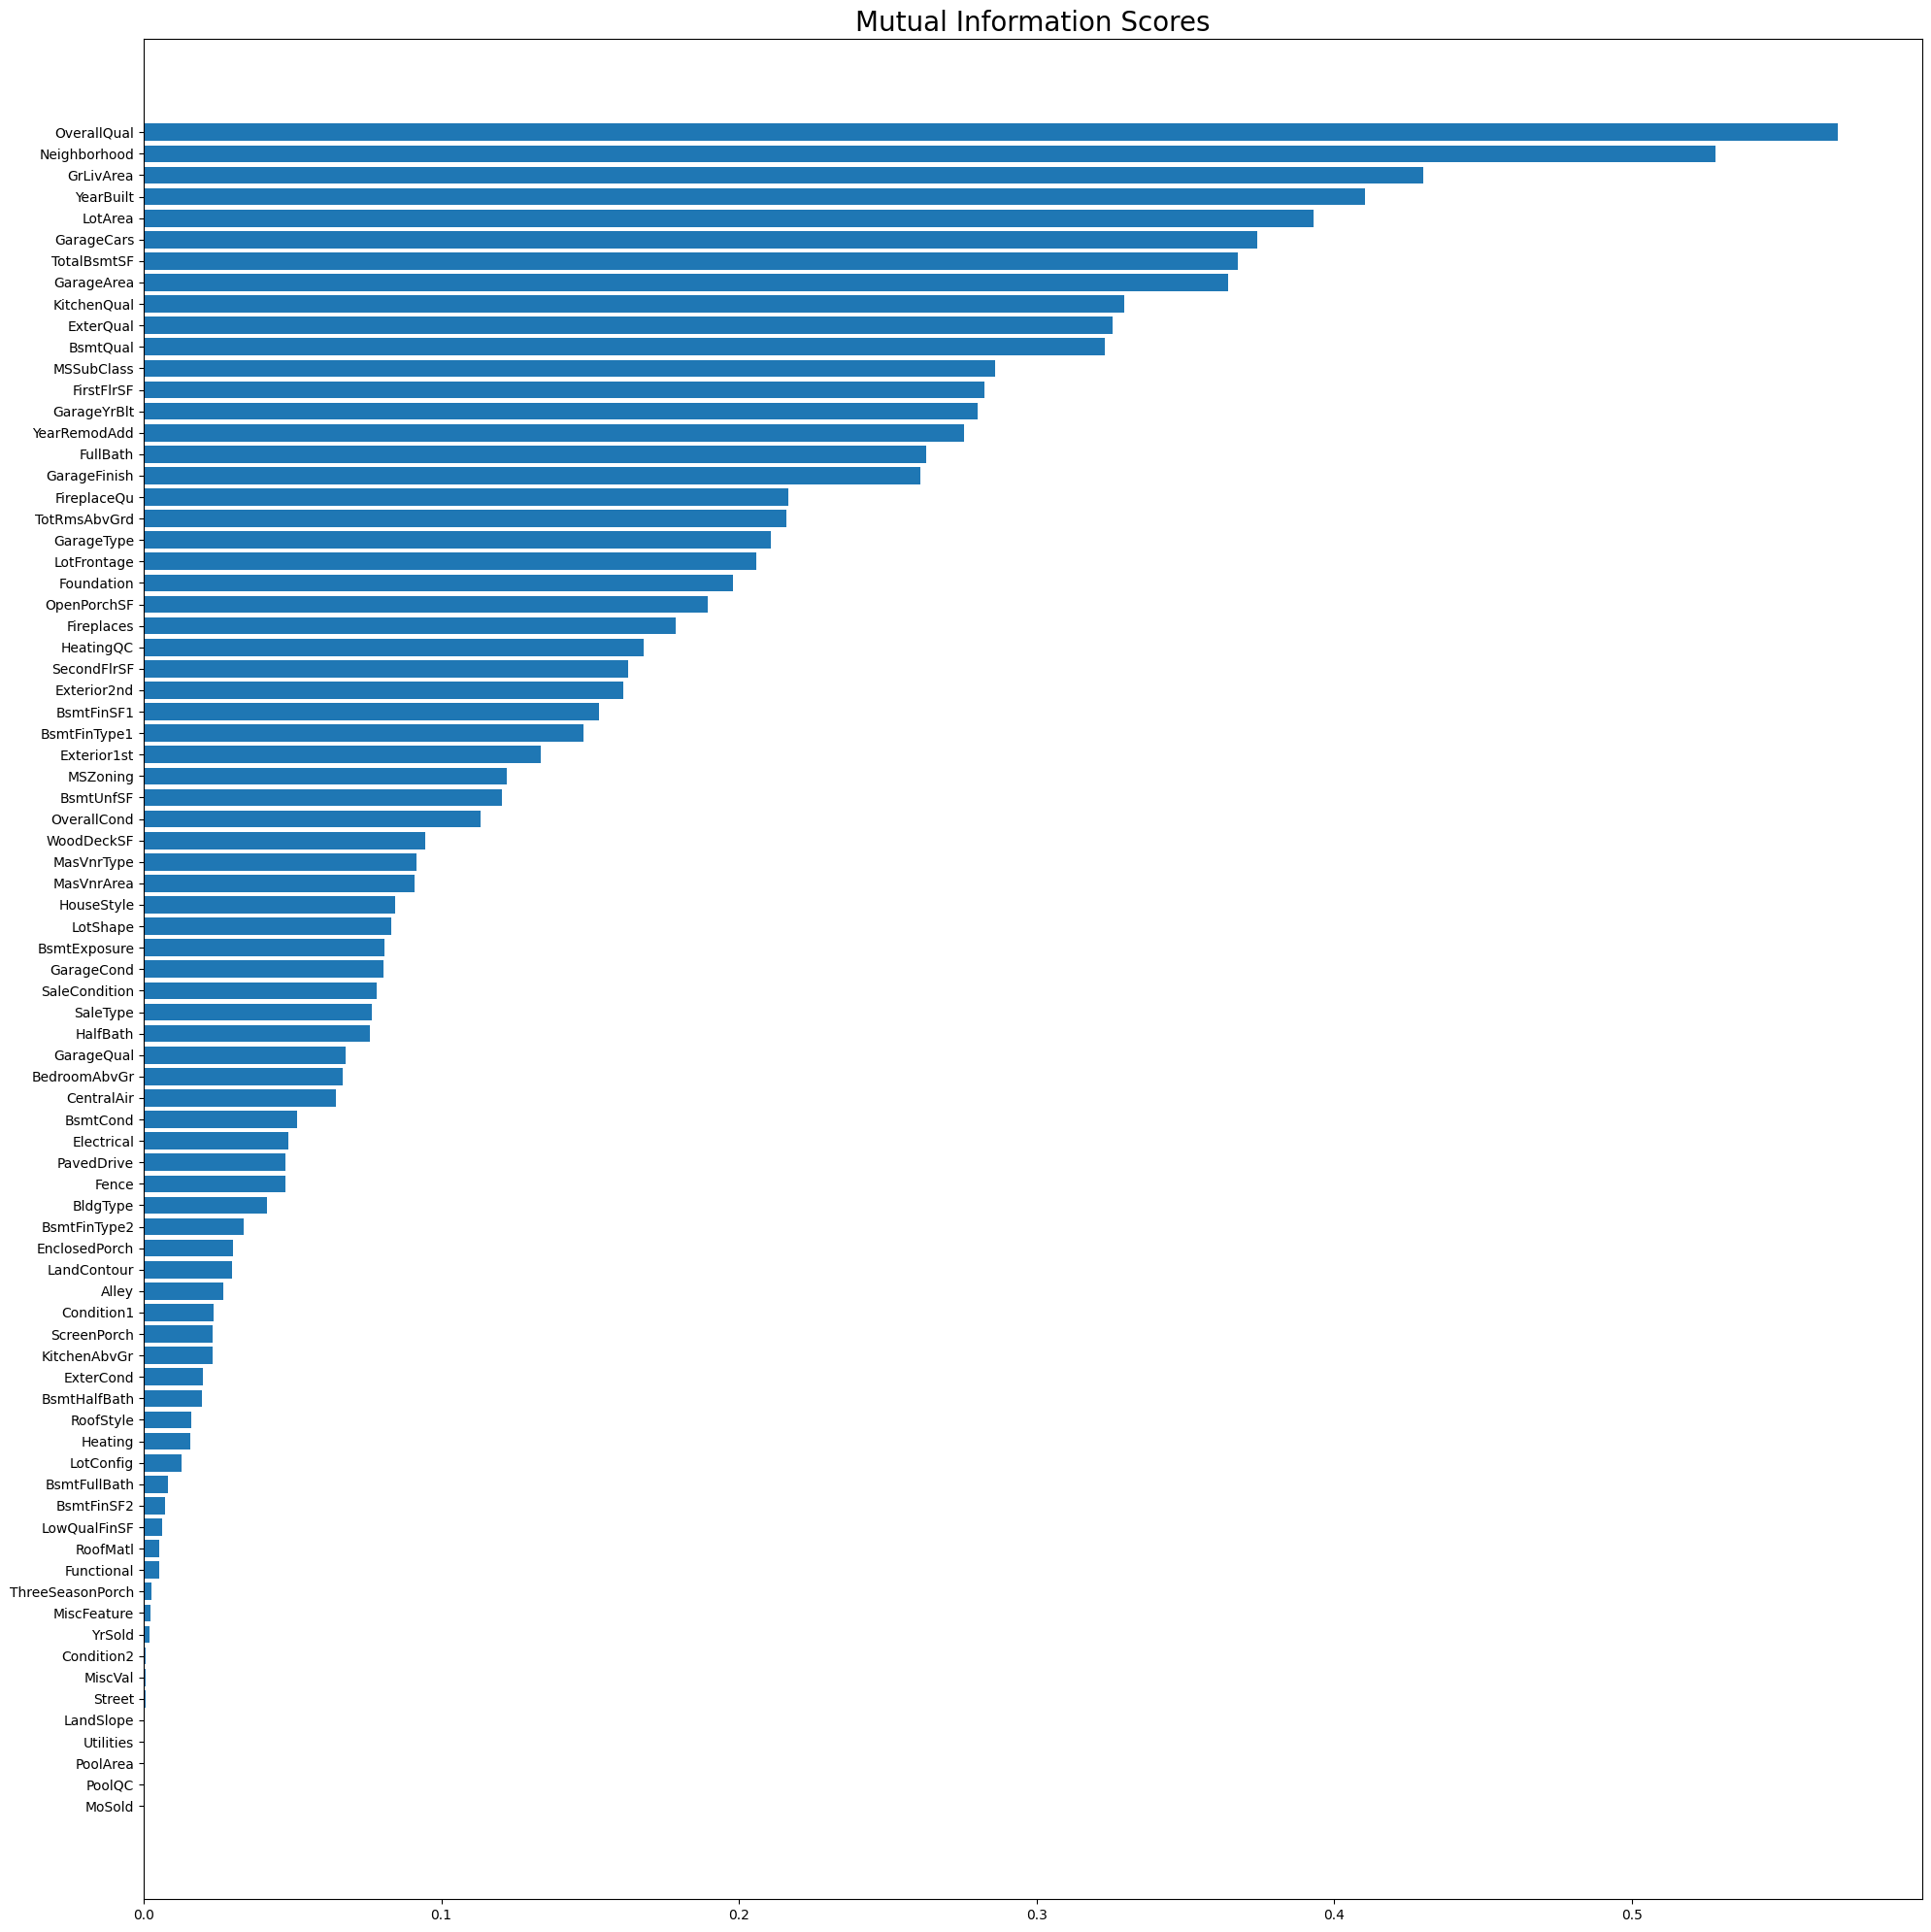

In [1229]:
# Design a testing function
def make_mi_score(X,Y):
    X = X.copy()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
        
    mi_scores = mutual_info_regression(X,Y,discrete_features=discrete_features,random_state=42)

    mi_scores = pd.Series(mi_scores,name='MI Scores',index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

# Visualize the above result

def plot_score(scores):
    scores = scores.sort_values(ascending=True)


    width = np.arange(len(scores))
    ticks = list(scores.index)

    plt.figure(figsize=(20,20))
    plt.barh(width,scores)
    plt.yticks(width,ticks)
    plt.title('Mutual Information Scores',size=20)
    plt.tight_layout()
    plt.show()

mi_scores = make_mi_score(X,Y)
plot_score(mi_scores)

In [1157]:
# As shown above, there are some values that is completely useless, currently, it doens't affect the training score
def which_drop(df,mi_score):
    df = df.copy()
    for i in [0.1,0.01,0.001,0.0001,0]:
        df = df.loc[:,mi_score > i]

        print(f'When drop the feature with score lower than {i}, the rsmle is {score_base(X,Y)}')

which_drop(X,mi_scores)

When drop the feature with score lower than 0.1, the rsmle is 0.133488672012182
When drop the feature with score lower than 0.01, the rsmle is 0.133488672012182
When drop the feature with score lower than 0.001, the rsmle is 0.133488672012182
When drop the feature with score lower than 0.0001, the rsmle is 0.133488672012182
When drop the feature with score lower than 0, the rsmle is 0.133488672012182


However, when we look back at XGboost, it is a TREE MODEL. It is smart enough to know what to ignore. 

Zero or Non-zero might make huge difference. While some features themselves have close to zero score, but they together may form a storng signal. 

So in a word, we shall not drop the features now and start to create new useful features. 

As a common sence, when purchasing a house, the 'TotalLivingArea' of the house is often talked about. However, this kind of features that represents the overall number / quality of sth is incomplete here. So first we will do simple feature aggregation. 

In [1234]:
# Define a function to create 

def aggregation_feature(df):
    df = df.copy()
    # The total living area
    df['TotalLivArea'] = df['FirstFlrSF'] + df['SecondFlrSF'] + df['TotalBsmtSF']
    # The multiplication of two strong features -- a big house with high quality tend to have higher price
    df['QualityTimesArea'] = df['OverallQual'] * df['TotalLivArea']
    # Sum the higly important quality features
    df['HomeQual'] = df['OverallQual'] + df['KitchenQual'] + df['ExterQual']
    # Also, the ratio of living and lot area might also be important
    df['LivLotRatio'] = df['TotalLivArea'] / df['LotArea']

    return df

all_data = aggregation_feature(all_data)

X1 = all_data[:1460].drop('SalePrice',axis=1)

updated_score = score_base(X1,Y)

print(f'After general aggregation, the rsmle is {updated_score}')

After general aggregation, the rsmle is 0.1315791450492229


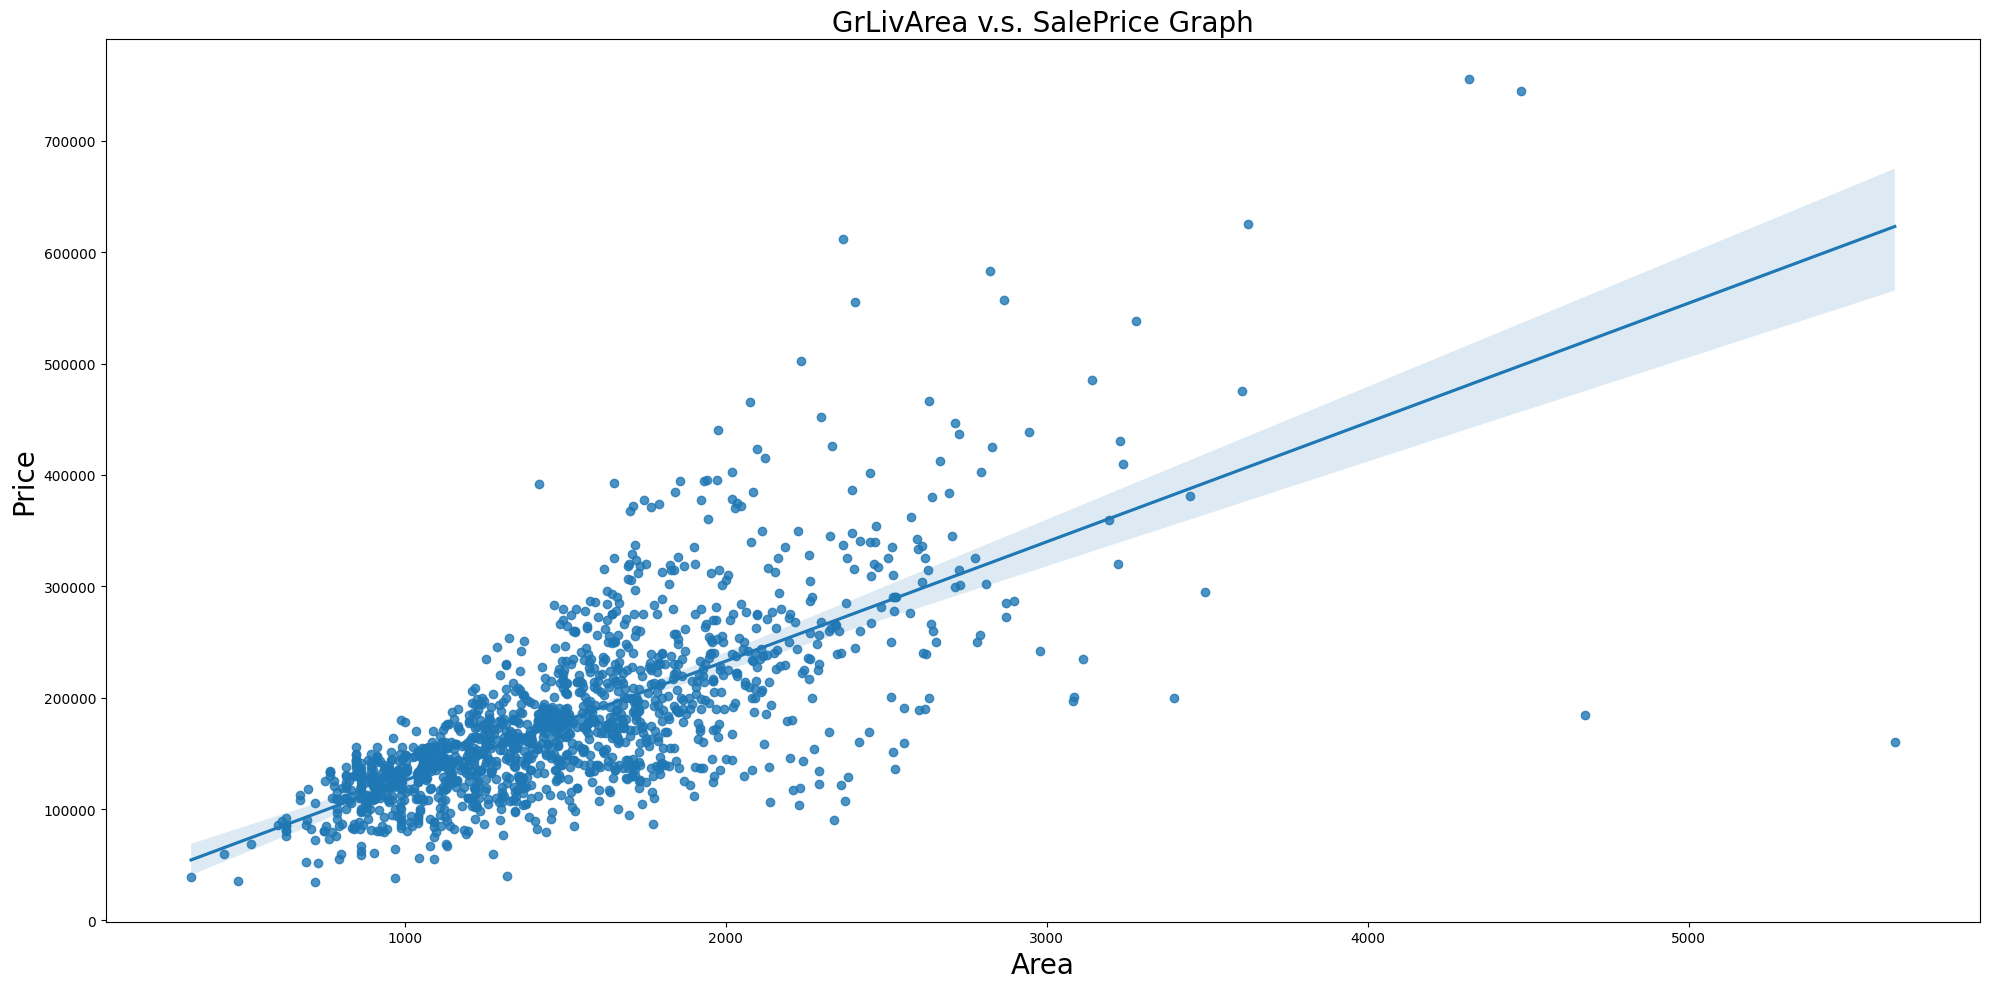

In [1235]:
# Next, lets analyze the GrLivArea vs SalePrice and see if there is sth unusual
plt.figure(figsize=(20,10))
def plot_area_price(df):
    df = df.copy()
    df = df[:1460]
    sns.regplot(data=df, x='GrLivArea', y='SalePrice', 
                scatter=True)
    plt.title('GrLivArea v.s. SalePrice Graph',size=20)
    plt.ylabel('Price',size=20)
    plt.xlabel('Area',size=20)
    plt.tight_layout()
    plt.show()

plot_area_price(all_data)

As shown above, there are two house with really large area but low saleprice, them together might be a big 'noise' to the model. We will drop them 

In [1204]:
# drop the two 'noise' point

def drop_noise(df): 
    df = df.copy()
    a = all_data[all_data['GrLivArea'] > 4000]
    b = a[a['SalePrice'] < 300000]  # Find the two points

    df = df.drop(b.index)
    return df
    
all_data1 = drop_noise(all_data)
X2 = all_data1[:1458].drop('SalePrice',axis=1)
Y2 = all_data1[:1458]['SalePrice']


print(f'After dropping two points, rsmle = {score_base(X2,Y2)}')

After dropping two points, rsmle = 0.1252674267320261


Still obersving the graph above, 'Porch' related features are also important. 

Now we try to create a feature that tells the model the total area of porch / and if they have porch or not

In [1236]:
# Create New Feature representing the total type of porch a house has

def porch_aggregation(df):
    df = df.copy()
#    df['TotalPorchSF'] = (df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + 
#    df['ThreeSeasonPorch'] + df['ScreenPorch'])

    #Also, if there is porch or not
#    df['HasPorch'] = df['TotalPorchSF'].apply(lambda x: 1 if x>0 else 0)
    
    return df

# Also, neighborhood area might be a key feature when choosing house
def neighbor_area(df):
    df = df.copy()
#    df['NeighborArea'] = df.groupby('Neighborhood')['GrLivArea'].transform('median')
    return df

all_data7 = porch_aggregation(all_data1)
all_data7 = neighbor_area(all_data1)

X3 = all_data7[:1458].drop('SalePrice',axis=1)

print(f'After this aggregation, rsmle = {score_base(X3,Y2):.5f}')

After this aggregation, rsmle = 0.12527


#### This is controversial (ignored for now)
Then, there is one thing important for linear models like (Ridge, lasso..) What if there is a extreme value there? 

Without any feature engineering here, the model will try to draw the line reaching the 'billionare' value, which will ruin other predictions. 

So here we will identify those highly skewed features and fix them.

In [1162]:
all_data['Alley'].value_counts()

Alley
1    2721
0     120
2      78
Name: count, dtype: int64

In [1163]:
#def fix_skew(df):
#    df = df.copy()

#    numeric_features = df.dtypes[df.dtypes != "object"].index
#    skewed_features = df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
#    high_skew = skewed_features[abs(skewed_features) >= 0.75]
#    skewed_feat = high_skew.index  # Finally identify high skew features
#
    # List them
#    print(f"Detected {len(skewed_feat)} skewed features.")
#    print("Top 5 Skewed:", list(skewed_feat[:5]))

#    for feature in skewed_feat:
#        df[feature] = np.log1p(df[feature])

#    return df
#
#all_data = fix_skew(all_data)
#X4 = all_data[:1458].drop('SalePrice',axis=1)

#print(f'After fixing skewness, rsmle = {score_base(X4,Y2):.5f}')

Now we conduct clustering. 

In [1237]:
# Define what helps us to cluster

cluster_features = ['LotArea','TotalBsmtSF','FirstFlrSF','SecondFlrSF','GrLivArea']

# Define a cluster label function: 
def k_cluster(df,features,n_clusters=10, fitted_objects=None):
    df = df.copy()
    target = df[features]
    if fitted_objects is None:
        scaler = StandardScaler()
        kmeans = KMeans(n_clusters=n_clusters,n_init=50,random_state=42)
        
        scaled_target = scaler.fit_transform(target)
        kmeans.fit(scaled_target)
        fitted_objects = (scaler, kmeans)
    else: 
        # Prevent data leakage, this is designed for Test set
        scaler,means = fitted_objects
        scaled_target = scaler.fit_transform(target)

    df['Cluster'] = kmeans.predict(scaled_target)

    return df,fitted_objects

In [1190]:
all_data['Neighborhood']

0        5
1       24
2        5
3        6
4       15
        ..
2914    10
2915    10
2916    11
2917    11
2918    11
Name: Neighborhood, Length: 2919, dtype: int8

Principal Component Analysis (PCA): 
It seperates / flattens features into dimensions, look through the data from each dimensions. 

It rotares data to find the best 'angle' 

But as for now I aim to use XGBoost, it is not necessary. 

In [1166]:
# We leave a blank here for potential PCA operation

Target encoding: 
'Neighborhood' not only differs in category, but also can show the price difference in different neighbors. So only label encoding is not enough for this kind of fearture.

Here we will operate further targte encoding for them. 

In [1266]:
# Define the target encoding function,n_splits indicate that the training data will be
# divided into 5 parts, we will take the average value at last
def target_encode(df,cols,y=None, target_col = 'SalePrice',n_splits=5, fitted_objects=None):
    df = df.copy()

    # Make sure the data type of feature is string
    for col in cols:
        df[col] = df[col].astype(str)

    # In order to prevent data leakage -- we train the encoder with training set
    # The 'if' loop is designed to have a encoder and then we can take it as an input to only
    # train the test set
    if fitted_objects is None:
        if y is None:
            raise ValueError("Training Mode: You MUST provide 'y' (SalePrice)!")

        # this is used to shuffle the data and split
        kf = KFold(n_splits = n_splits,shuffle=True,random_state=42)

        # This is to stroe one encoder per fold
        fitted_encoders = []

        # The result of target encoded data will the a new column
        result = pd.DataFrame(index=df.index,columns=[c + "Encoded" for c in cols])
        y = y.reset_index(drop=True)
        df = df.reset_index(drop=True)

        # Loop through every splited group of train data
        for train_index,val_index in kf.split(df):
            x_train_fold = df.iloc[train_index]
            y_train_fold = y.iloc[train_index]
            x_val_fold = df.iloc[val_index]

            # Initialize and fit encoder on training dataset
            # We can also use different encoder here
            ###### We will try CatBoostEncoder later ######
            encoder = CatBoostEncoder(cols=cols,a=1.0,sigma=None)
            encoder.fit(x_train_fold,y_train_fold)

            # The output value is gonna be the encoded value
            encoded_value = encoder.transform(x_val_fold)[cols]
            encoded_value.columns = [c + "Encoded" for c in cols]

            result.iloc[val_index] = encoded_value
            fitted_encoders.append(encoder)

        # Add this into training set
        result.index = df.index
        df = pd.concat([df,result],axis=1)
        fitted_objects = fitted_encoders

    else: 
        # THis is the testing mode, using existing encoders
        fitted_encoders = fitted_objects
        encoded_list = []

        # Now we already have the encoder, we just have to encode test set with this
        for encoder in fitted_encoders:
            temp_encoded = encoder.transform(df)[cols]
            temp_encoded.columns = [c + "Encoded" for c in cols]
            encoded_list.append(temp_encoded)
        # This is taking the mean value of five encoded value
        mean_encoded = reduce(lambda x,y: x.add(y,fill_value=0),encoded_list) / len(encoded_list)
        df = pd.concat([df,mean_encoded],axis=1)

    return df,fitted_objects

target_encoded_columns = ['Neighborhood','MSSubClass']

### Final feature creation summary and data split

In [1274]:
def create_feature(df):
    # The required test set starts at the 
    train_len = 1460
    train = df.iloc[:train_len].copy()
    train = train.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)
    X_test = df.iloc[train_len:].copy()

    Y_train = train['SalePrice']

    cols_drop = ['SalePrice', 'Id']
    X_train = train.drop(cols_drop, axis=1, errors='ignore')
    X_test = X_test.drop(cols_drop, axis=1, errors='ignore')

    target_cols = ['Neighborhood', 'MSSubClass']
    X_train, rules = target_encode(X_train, target_cols, y=Y_train)
    X_test, _ = target_encode(X_test, target_cols, fitted_objects=rules)
    
    X_train = X_train.drop(target_cols, axis=1)
    X_test = X_test.drop(target_cols, axis=1)

    print(f"Train Shape: {X_train.shape}")
    print(f"Test Shape:  {X_test.shape}")
    
    return X_train, Y_train, X_test

X_train, Y_train, X_test = create_feature(all_data)

Train Shape: (1458, 83)
Test Shape:  (1459, 83)


#### After data preparation, we will try to find a good set of parameters in our XGBoostRegressor, so here we use Optuna

In [1275]:
# Remember there is a data type problem, what is the datatype of target encoded feature?

for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

X_train.select_dtypes(include=['object']).columns.tolist()

[]

In [1276]:
# Now define the trial function for optimizing

def objective(trial):
    parameters = dict(
        max_depth=trial.suggest_int('max_depth',3,6),
        learning_rate=trial.suggest_float('learning_rate',1e-4,5e-2,log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 6000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )

    XGB = XGBRegressor(**parameters)
    return score_base(X_train,Y_train,XGB)

study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=20)
xgb_parameters = study.best_params

[I 2025-11-30 13:12:25,290] A new study created in memory with name: no-name-89f6d8ed-daac-440e-91cd-b83c5668e5b5
[I 2025-11-30 13:12:32,919] Trial 0 finished with value: 0.13604097301314755 and parameters: {'max_depth': 6, 'learning_rate': 0.005061651179148548, 'n_estimators': 1753, 'min_child_weight': 4, 'colsample_bytree': 0.2760466639124344, 'subsample': 0.2927206074604373, 'reg_alpha': 1.0053379718938886, 'reg_lambda': 17.724784501055648}. Best is trial 0 with value: 0.13604097301314755.
[I 2025-11-30 13:12:36,988] Trial 1 finished with value: 0.1456679143452573 and parameters: {'max_depth': 3, 'learning_rate': 0.0017243860864925302, 'n_estimators': 1457, 'min_child_weight': 4, 'colsample_bytree': 0.5502658205675258, 'subsample': 0.31750383037653995, 'reg_alpha': 0.0005649750365709119, 'reg_lambda': 0.12400697070910233}. Best is trial 0 with value: 0.13604097301314755.
[I 2025-11-30 13:12:39,658] Trial 2 finished with value: 0.1148091261442724 and parameters: {'max_depth': 3, 'lea

Below is an aggressive way of handling the learning rate and n_estimators, based on reality, if we use the conservative dropping rate as 2, the model performence is better. 

In [1260]:
#final_params = xgb_parameters.copy()

#final_params['learning_rate'] = 0.002
#final_params['n_estimators'] = 10000

# Now we already have the final set of parameters, we have to make the model: 
# think slower, think more carefully - by adjusting how many trees it develops and the learning rate
# But, how to decide the rate of dropping? -- early stopping solution
# set a huge number first 
#model = XGBRegressor(**final_params,early_stopping_rounds=100,)

# We have to monitor the process of finding the drop rate

#X_part,X_val,Y_part,Y_val = train_test_split(X_train,Y_train,
                                             test_size=0.15,random_state=42)

#model.fit(
#    X_part,np.log1p(Y_part),
#    eval_set=[(X_val,np.log1p(Y_val))],
#    verbose=False
#)

#print(f'Model stopped when the tree number is {model.best_iteration}')

Model stopped when the tree number is 5363


In [1261]:
# Now we have all we need, just train the final model, and predict

final_params = xgb_parameters.copy()

final_params['learning_rate'] = final_params['learning_rate'] * 2
final_params['n_estimators'] = final_params['n_estimators'] / 2

final_model = XGBRegressor(**final_params)
final_model.fit(X_train,np.log1p(Y_train))

log_predictions = final_model.predict(X_test)

final_predictions = np.expm1(log_predictions)

In [1246]:
#lasso = make_pipeline(
#    RobustScaler(),
#    LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
#            max_iter=50000, cv=10)
#)
#lasso.fit(X_train.fillna(0),np.log1p(Y_train))

#lasso_predictions = np.expm1(lasso.predict(X_test.fillna(0)))

In [1262]:
score = score_base(X_train,Y_train,model=final_model)
#final_predictions = 0.7 * xgb_predictions + 0.3 * lasso_predictions

In [1265]:
output = pd.DataFrame({'Id': (X_test.index+1), 'SalePrice': final_predictions})
output.to_csv('my_submission5.csv',index=False)
predictions.shape[0]

1459

In [1256]:
import pandas as pd

def check_submission(filename):
    print(f"Checking: {filename} ...")
    
    # 1. Try to read it
    try:
        df = pd.read_csv(filename)
    except Exception as e:
        print(f"❌ FATAL: Could not read CSV. Error: {e}")
        return

    # 2. Check Dimensions
    rows, cols = df.shape
    print(f"  Shape: {rows} rows, {cols} columns")
    
    if rows != 1459:
        print(f"  ❌ ERROR: Expected 1459 rows, found {rows}. (Did you drop a test row?)")
    else:
        print("  ✅ Rows: Correct (1459)")

    if cols != 2:
        print(f"  ❌ ERROR: Expected 2 columns, found {cols}. (Did you forget index=False?)")
    else:
        print("  ✅ Columns: Correct (2)")

    # 3. Check Headers
    required_cols = {'Id', 'SalePrice'}
    current_cols = set(df.columns)
    if current_cols != required_cols:
        print(f"  ❌ ERROR: Column names are wrong. Found: {current_cols}. Expected: {required_cols}")
    else:
        print("  ✅ Headers: Correct ('Id', 'SalePrice')")

    # 4. Check ID Type
    if 'Id' in df.columns:
        if pd.api.types.is_float_dtype(df['Id']):
             print("  ⚠️ WARNING: 'Id' is Float (1461.0). Kaggle prefers Int (1461).")
             # Fix it suggests
             print("     -> Fix: submission['Id'] = submission['Id'].astype(int)")
        else:
             print("  ✅ Id Type: Integer")

    print("\n--- Check Complete ---")

# Replace with your actual filename
check_submission('my_submission4.csv')

Checking: my_submission4.csv ...
  Shape: 1459 rows, 2 columns
  ✅ Rows: Correct (1459)
  ✅ Columns: Correct (2)
  ✅ Headers: Correct ('Id', 'SalePrice')
  ✅ Id Type: Integer

--- Check Complete ---
